# Introduction

Yoga is a popular practice known for its ability to alleviate stress and anxiety. With numerous poses available, including well-known ones like downward dog, goddess, tree, plank, and warrior, distinguishing between them can be challenging, especially for beginners. Leveraging smart technology, such as machine learning, can aid in automatically classifying and identifying these poses. In this project, we explore the application of deep learning techniques to develop a model capable of accurately recognizing and categorizing various yoga poses. By harnessing the power of computer vision and convolutional neural networks (CNNs), we aim to create a system that not only assists practitioners in refining their techniques but also provides valuable insights for yoga instructors and enthusiasts alike.

### Importing necessary modules:

In [22]:

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import shutil
from tensorflow.keras.applications import VGG19


from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import os
import shutil
import random


### Intializing directiores:

In [23]:


# Define the base directory containing the dataset
base_dir = "/kaggle/input/yoga-poses-dataset"

# Define the directory containing the dataset
dataset_dir = os.path.join(base_dir, "DATASET")

# Define the directory for training data
train_dir = os.path.join(dataset_dir, "TRAIN")

# Define the directory to save the validation data
validation_dir = "/kaggle/working/VALIDATION"
val_dir  = validation_dir
test_dir = "/kaggle/input/yoga-poses-dataset/DATASET/TEST"
# Create validation directory if it doesn't exist
os.makedirs(validation_dir, exist_ok=True)

# Define a function to split data into train/validation in-memory
def split_data(files, split_ratio):
    random.shuffle(files)
    split_index = int(len(files) * split_ratio)
    return files[:split_index], files[split_index:]

# Iterate over categories
for category in os.listdir(train_dir):
    # Define directories for each category
    category_train_dir = os.path.join(train_dir, category)
    category_validation_dir = os.path.join(validation_dir, category)
    
    # Create category validation directory if it doesn't exist
    os.makedirs(category_validation_dir, exist_ok=True)
    
    # List files in the category training directory
    files = os.listdir(category_train_dir)
    
    # Split data into train/validation
    validation_files, remaining_files = split_data(files, 0.2)
    
    # Move validation files to validation directory
    for file in validation_files:
        src = os.path.join(category_train_dir, file)
        dst = os.path.join(category_validation_dir, file)
        shutil.copy(src, dst)

print("Validation data saved as directories.")


Validation data saved as directories.


###  **Understanding the dataset:**

In [24]:
# Initialize empty lists for labels and corresponding image counts
labels = []
train_counts = []

# Iterate over directories in the training directory
for dirname in os.listdir(train_dir):
    # Append the directory name (label) to the labels list
    labels.append(dirname)
    
    # Initialize image count for the current directory
    image_count = 0
    
    # Iterate over images in the current directory
    for img in os.listdir(os.path.join(train_dir, dirname)):
        # Increment image count for each image found
        image_count += 1
    
    # Append the total image count for the current directory to the train_counts list
    train_counts.append(image_count)


#### Various classes with number of images in training data:

In [25]:
print(labels)
print(train_counts)

['downdog', 'tree', 'plank', 'warrior2', 'goddess']
[223, 160, 266, 252, 180]


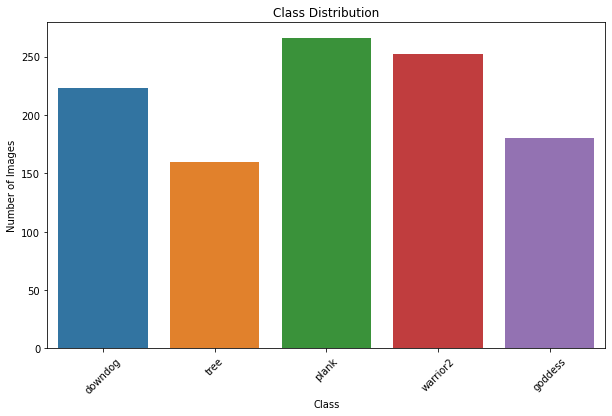

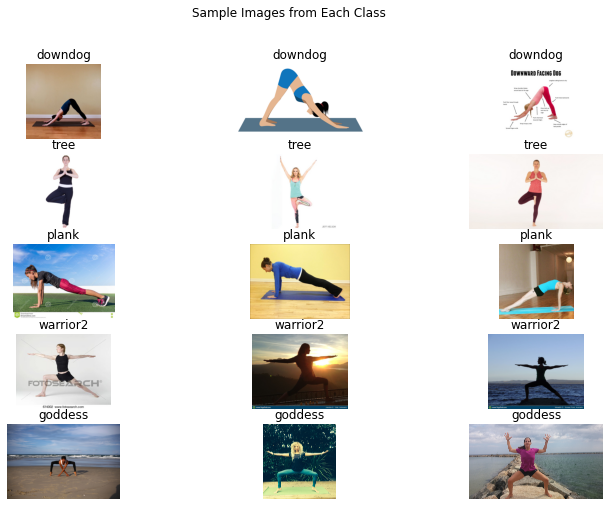

In [26]:

# Function to plot the class distribution of images in a directory
def plot_class_distribution(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_counts[class_name] = len(os.listdir(os.path.join(directory, class_name)))
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

# Function to display sample images from each class in a directory
def display_sample_images(directory, num_samples=3):
    plt.figure(figsize=(12, 8))
    for i, class_name in enumerate(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        sample_images = os.listdir(class_dir)[:num_samples]
        for j, image_name in enumerate(sample_images):
            image_path = os.path.join(class_dir, image_name)
            image = Image.open(image_path)
            plt.subplot(5, num_samples, i * num_samples + j + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis('off')
    plt.suptitle('Sample Images from Each Class')
    plt.show()

# Function to visualize data augmentation on a generator
def visualize_data_augmentation(generator, num_samples=5):
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        augmented_image, _ = generator.next()
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(augmented_image[0])
        plt.axis('off')
        plt.title('Augmented Image')
    plt.suptitle('Visualizing Data Augmentation')
    plt.show()

# Perform EDA
plot_class_distribution(train_dir)
display_sample_images(train_dir)






### Data Augmentation:

In [27]:
# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to the range [0, 1]
    shear_range=0.2,  # Apply shear transformation with a range of 0.2
    zoom_range=0.2,   # Apply random zooming with a range of 0.2
    horizontal_flip=True  # Flip images horizontally
)

# Data augmentation for validation images
valid_datagen = ImageDataGenerator(
    rescale=1. / 255  # Rescale pixel values to the range [0, 1]
)


In [28]:
# Generating batches of augmented training data
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=16,             # Number of samples per batch
                                                    class_mode='categorical',  # Type of labels (categorical for multi-class classification)
                                                    target_size=(150, 150),    # Resizing images to (150, 150)
                                                    shuffle=True)              # Shuffling the data

# Generating batches of validation data (without augmentation)
valid_generator = valid_datagen.flow_from_directory(val_dir,
                                                    batch_size=16,             # Number of samples per batch
                                                    class_mode='categorical',  # Type of labels (categorical for multi-class classification)
                                                    target_size=(150, 150),    # Resizing images to (150, 150)
                                                    shuffle=False)             # No shuffling for validation data


Found 1081 images belonging to 5 classes.
Found 381 images belonging to 5 classes.


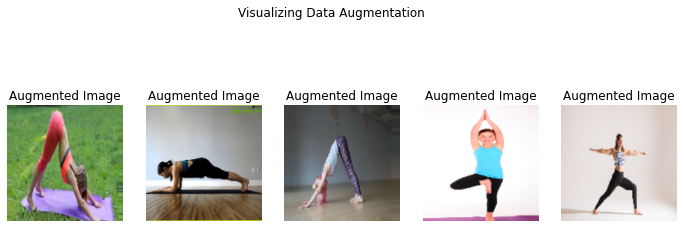

In [29]:
visualize_data_augmentation(train_generator)

In [30]:


# Creating an ImageDataGenerator object for test data with rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Generating batches of augmented data from the test directory
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  target_size=(150, 150),
                                                  shuffle=False)


Found 470 images belonging to 5 classes.


### **Assigning weights to classes:**

In [31]:
# Initializing an empty list to store class weights
class_weights = []

# Calculating total number of samples
total_samples = train_generator.samples

# Calculating total number of classes
total_classes = len(train_generator.class_indices)

# Calculating class weights for each class
for ele in train_counts:
    result = round(total_samples / (total_classes * ele), 2)
    class_weights.append(result)

# Creating a dictionary mapping class indices to their respective weights
class_weights = dict(zip(train_generator.class_indices.values(), class_weights))

# Printing the calculated class weights
print(class_weights)


{0: 0.97, 1: 1.35, 2: 0.81, 3: 0.86, 4: 1.2}


In [32]:
# Clearing the Keras session to release memory and prevent slowdowns
tf.keras.backend.clear_session()

# Setting the random seed for TensorFlow to ensure reproducibility
tf.random.set_seed(42)

# Setting the random seed for NumPy to ensure reproducibility
np.random.seed(42)


### **VGG19-Model**

In [33]:
def custom_model():
    """
    Function to create a custom model based on VGG19 architecture for transfer learning.

    Parameters:
    None

    Returns:
    model: Custom model with VGG19 base and additional layers for classification.
    """

    # Load the pre-trained VGG19 model with weights from ImageNet dataset
    cus_model = VGG19(input_shape=(150, 150, 3),        
                      weights='imagenet', 
                      include_top=False)

    # Freeze the layers of the pre-trained model to retain pre-learned features
    for layer in cus_model.layers:
        layer.trainable = False

    # Add custom layers for classification on top of the pre-trained model
    x = layers.Flatten()(cus_model.output)
    x = layers.Dense(512, activation='relu')(x)  # Add a fully connected layer with ReLU activation
    x = layers.Dropout(0.2)(x)  # Add dropout regularization to prevent overfitting
    x = layers.Dense(5, activation='softmax')(x)  # Add output layer with softmax activation for multi-class classification

    # Define the final custom model
    model = Model(cus_model.input, x)
    
    return model


### **Structure of the model:**

# Utilizing VGG19 Model for Yoga Pose Detection

In the task of yoga pose detection, choosing an appropriate convolutional neural network (CNN) architecture is crucial to ensure effective feature extraction and classification. Here, we opted to utilize the VGG19 model for several reasons:

## Why VGG19?
- **Deep Architecture**: VGG19 is a deep CNN architecture that has demonstrated strong performance in various computer vision tasks, including image classification.
- **Simplicity and Effectiveness**: VGG19's architecture is characterized by its simplicity, comprising multiple convolutional layers followed by max-pooling layers. Despite its straightforward design, VGG19 has shown impressive performance on challenging datasets.
- **Pre-trained Weights**: VGG19 has been pre-trained on the ImageNet dataset, a large-scale dataset containing millions of labeled images across thousands of classes. Leveraging pre-trained weights allows the model to capture rich hierarchical features that can be beneficial for transfer learning.
- **Transfer Learning**: Transfer learning with VGG19 enables us to leverage features learned from generic image recognition tasks and adapt them to the specific task of yoga pose detection.

## Architecture Decision
- **Feature Extraction**: The convolutional layers of VGG19 are effective for feature extraction from input images. These layers progressively learn abstract representations of visual features, which are essential for distinguishing between different yoga poses.
- **Classification Layers**: While VGG19 was originally designed for image classification with 1,000 classes, we modified the architecture by replacing the original fully connected layers with custom layers suitable for our classification task. This involved adding a global average pooling layer followed by one or more dense layers with appropriate activation functions.
- **Output Layer**: The output layer of the modified VGG19 architecture consists of neurons corresponding to the number of yoga poses/classes we aim to detect. We utilize softmax activation to obtain class probabilities, indicating the likelihood of an input image belonging to each pose category.

By employing VGG19 as the backbone architecture and customizing the fully connected layers for classification, we aim to develop a robust and accurate model for yoga pose detection. This approach combines the strengths of deep learning architectures with the flexibility of transfer learning, ultimately facilitating the recognition of yoga poses from images.


In [34]:
model = custom_model()
model.summary()

80142336/80134624 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

### **Callbacks:**

In [35]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)

    return exponential_decay_fn


exponential_decay_fn = exponential_decay(lr0=0.0009, s=5)

lr_scheduler_ed = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# Checkpoint callback
# checkpoint_cb = keras.callbacks.ModelCheckpoint("yoga_model.h5", save_best_only=True)

# Early stopping callback
early_stopping_m = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

### **Compiling the model:**

In [36]:
model.compile(
    optimizer='adam',  # Adam optimizer for efficient gradient descent
    loss='categorical_crossentropy',  # Categorical crossentropy loss for multi-class classification
    metrics=['accuracy']  # Accuracy metric to monitor model performance during training
)


### **Fitting the model:**

In [37]:
history = model.fit(
    train_generator,  # Training data generator
    validation_data=valid_generator,  # Validation data generator
    epochs=30,  # Number of epochs for training
    batch_size=32,  # Batch size for each iteration
    callbacks=[lr_scheduler_ed, early_stopping_m],  # Callbacks for dynamic learning rate scheduling and early stopping
    verbose=1  # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
)


Epoch 1/30


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


68/68 [==============================] - 30s 395ms/step - loss: 2.1966 - accuracy: 0.4493 - val_loss: 0.3935 - val_accuracy: 0.8583
Epoch 2/30
68/68 [==============================] - 26s 375ms/step - loss: 0.4419 - accuracy: 0.8443 - val_loss: 0.2559 - val_accuracy: 0.9344
Epoch 3/30
68/68 [==============================] - 25s 377ms/step - loss: 0.3107 - accuracy: 0.9082 - val_loss: 0.2282 - val_accuracy: 0.9291
Epoch 4/30
68/68 [==============================] - 26s 376ms/step - loss: 0.2303 - accuracy: 0.9444 - val_loss: 0.1721 - val_accuracy: 0.9449
Epoch 5/30
68/68 [==============================] - 25s 375ms/step - loss: 0.1882 - accuracy: 0.9542 - val_loss: 0.1483 - val_accuracy: 0.9606
Epoch 6/30
68/68 [==============================] - 26s 373ms/step - loss: 0.2466 - accuracy: 0.9210 - val_loss: 0.1297 - val_accuracy: 0.9606
Epoch 7/30
68/68 [==============================] - 25s 375ms/step - loss: 0.1984 - accuracy: 0.9427 - val_loss: 0.1225 - val_accuracy: 0.9606
Epoch 8/30

### **Plotting Graphs:**

### Graph betweeen training accuracy and validation accuracy:

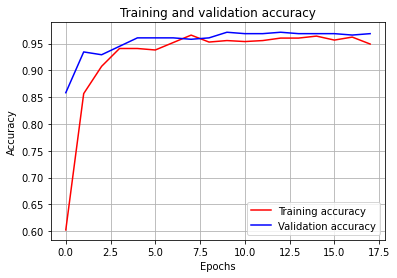

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [38]:
# Extracting training and validation accuracy from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting training and validation accuracy over epochs
plt.plot(history.epoch, acc, 'r', label='Training accuracy')
plt.plot(history.epoch, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()  # Displaying legend
plt.grid(True)  # Adding grid for better visualization
plt.show()  # Showing the plot
plt.figure()  # Creating a new figure for clear separation


### Graph between training loss and validation Loss:

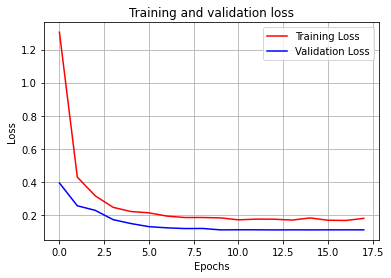

In [39]:
# Extracting training and validation loss from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting training and validation loss over epochs
plt.plot(history.epoch, loss, 'r', label='Training Loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()  # Displaying legend
plt.grid(True)  # Adding grid for better visualization
plt.show()  # Showing the plot


### Graph for learning rate ~ Exponential Decay

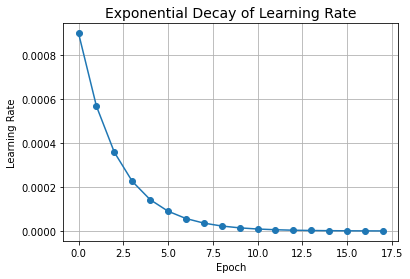

In [40]:
# Plotting the learning rate decay over epochs
plt.plot(history.epoch, history.history["lr"], "o-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Decay of Learning Rate", fontsize=14)
plt.grid(True)
plt.show()


### Plotting all the metrics in one graph

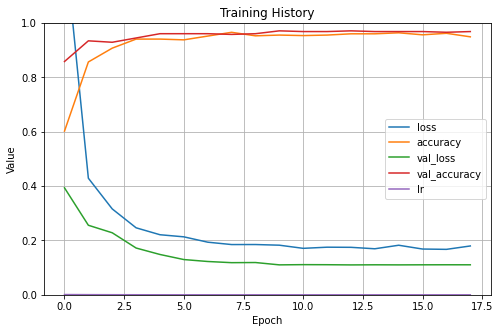

In [41]:

# Create a DataFrame from the history object
history_df = pd.DataFrame(history.history)

# Plotting the DataFrame
history_df.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)  # Set y-axis limits from 0 to 1 for better visualization of accuracy and loss
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()


### **Evaluate model with test dataset**

In [42]:
# Evaluate the model on the test data generator
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=1)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


262/470 [===============>..............] - ETA: 5s - loss: 0.1411 - accuracy: 0.9580

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


470/470 [==============================] - 15s 32ms/step - loss: 0.1222 - accuracy: 0.9702
Test Loss: 0.12219991534948349
Test Accuracy: 0.9702127575874329


### Confusion Matrix:

In [43]:


# Generate predictions for the test data
y_pred = model.predict(test_generator)
# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(test_generator.classes, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.95      0.97        97
           1       1.00      0.93      0.96        80
           2       0.94      0.99      0.97       115
           3       0.97      0.99      0.98        69
           4       0.96      0.99      0.98       109

    accuracy                           0.97       470
   macro avg       0.97      0.97      0.97       470
weighted avg       0.97      0.97      0.97       470



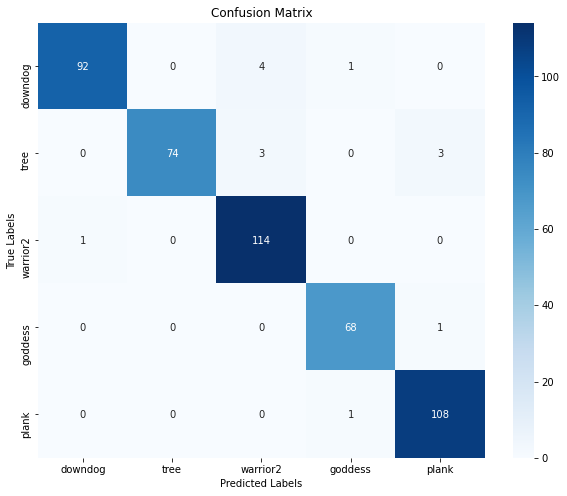

<Figure size 720x576 with 0 Axes>

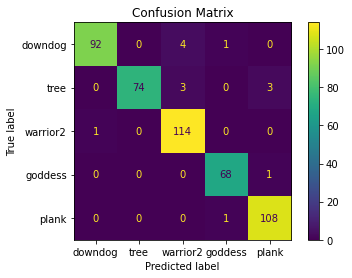

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate confusion matrix
cf_matrix = confusion_matrix(test_generator.classes, y_pred)

# Define class labels
Labels = ['downdog', 'tree', 'warrior2', 'goddess', 'plank']

# Plot confusion matrix with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=Labels, yticklabels=Labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot confusion matrix with sklearn's ConfusionMatrixDisplay
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=Labels)
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()